# Improve the ancestral probability layer

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('../learnMSA')
import numpy as np
import tensorflow as tf
from learnMSA import msa_hmm
from matplotlib import pyplot as plt
from pathlib import Path
import time
import pandas as pd

In [2]:
def convert_time(total_secs):
    secs, mins = np.modf(total_secs/60.)
    mins = int(mins)
    secs *= 60.
    return mins, secs

def make_dirs(name):
    results_path = "results/"+name
    Path(results_path+"/logs/").mkdir(parents=True, exist_ok=True)
    Path(results_path+"/times/").mkdir(parents=True, exist_ok=True)
    Path(results_path+"/alignments/").mkdir(parents=True, exist_ok=True)
    return results_path
    
def run_tests(runner_func, name, datasets=["homfam"], num_models=10):
    results_path = make_dirs(name)
    stdout = sys.stdout
    for dataset in datasets:
        for file in os.listdir("data/"+dataset+"/train"):
            if file.endswith(".fasta"):
                family = ".".join(file.split(".")[:-1])
                train_file = "../MSA-HMM-Analysis/data/"+dataset+"/train/" + file
                ref_file = "../MSA-HMM-Analysis/data/"+dataset+"/refs/" + family + ".ref"
                log_filepath = results_path+"/logs/"+family+".log"
                out_file = results_path+"/alignments/"+file
                if os.path.exists(out_file):
                    continue
                sys.stdout = open(log_filepath, "w")
                t = time.time()
                alignment, sp = runner_func(train_file, 
                                        ref_file, 
                                        out_file,
                                        msa_hmm.config.make_default(num_models))
                score_filepath = results_path + "/" + name + "." + dataset + ".out"
                with open(score_filepath, "a") as out_file:
                    out_file.write(f"{family} {sp} 0 0 0 0\n")
                aln_mins, aln_secs = convert_time(time.time() - t)
                sys.stdout.close()
                sys.stdout = stdout
                time_filepath = results_path+"/times/"+family+".time.txt"
                with open(time_filepath, "w") as time_file:
                    time_file.write(f"real\t{aln_mins}m{aln_secs}s\n") 
        
                    
def runner_func(train_file, ref_file, out_file, config):
    return msa_hmm.align.run_learnMSA(train_file,
                                               out_file,
                                                  config, 
                                                  ref_filename=ref_file, 
                                                  verbose=True)

def get_score(name, dataset):
    df = pd.read_csv(f"results/{name}/{name}.{dataset}.out", sep=" ", header=None)
    return df[1].mean()

In [3]:
#a simple "pseudocount" prior that penalizes all probabilities with the same alpha
#if categorical==True, the prior is a Dirichlet distribution over the k categories 
#otherwise, k Dirichlet's over Bernoulli distributions
class PseudoCountPrior():
    def __init__(self, alpha, insertions=False, categorical=True):
        self.alpha = alpha
        self.categorical = categorical
        self.insertions = insertions
        
    def load(self, dtype):
        pass
        
    def __call__(self, B, lengths):
        """Computes log pdf values for each match state.
        Args:
        B: A stack of k emission matrices. Shape: (k, q, s)
        Returns:
        A tensor with the log pdf values of the prior. Shape: (k, max_model_length)
        """
        max_model_length = tf.reduce_max(lengths)
        if self.insertions:
            B = B[:,:-1,:-1]
        else:
            B = B[:,1:max_model_length+1,:-1]
        prior = tf.math.log(B)
        prior = tf.reduce_sum(self.alpha * prior, -1) 
        #zero padding for non match states
        prior *= tf.cast(tf.sequence_mask(lengths), B.dtype)
        return prior
    
class ReduceMultinomialPrior():
    def __init__(self, num_rate_matrices, alpha, insertions=False, categorical=True):
        self.num_rate_matrices = num_rate_matrices
        self.pseudo_count_prior = PseudoCountPrior(alpha, insertions, categorical)
        self.amino_prior = msa_hmm.priors.AminoAcidPrior()
        
    def load(self, dtype):
        self.amino_prior.load(dtype)
        
    def __call__(self, B, lengths):
        return (self.pseudo_count_prior(B[:,:,:self.num_rate_matrices+1], lengths) 
                + self.amino_prior(B[:,:,self.num_rate_matrices+1:], lengths))

In [4]:
class ReduceMultinomialEmissionInitializer(tf.keras.initializers.Initializer):

    def __init__(self, num_rate_matrices):
        self.n = num_rate_matrices
        self.multinomial_init = msa_hmm.initializers.ConstantInitializer(0.)
        self.amino_initializer = msa_hmm.initializers.make_default_emission_init()

    def __call__(self, shape, dtype=None, **kwargs):
        assert len(shape) == 2, "ReduceMultinomialEmissionInitializer only supports 2D shapes."
        m = self.multinomial_init((shape[0], self.n), dtype, **kwargs)
        a = self.amino_initializer((shape[0], shape[1]-self.n), dtype, **kwargs)
        return tf.concat([m, a], axis=-1)
        
    def __repr__(self):
        return f"ReduceMultinomialEmissionInitializer()"
    
    
class ReduceMultinomialInsertionInitializer(tf.keras.initializers.Initializer):

    def __init__(self, num_rate_matrices):
        self.n = num_rate_matrices
        self.multinomial_init = msa_hmm.initializers.ConstantInitializer(0.)
        self.amino_initializer = msa_hmm.initializers.make_default_insertion_init()

    def __call__(self, shape, dtype=None, **kwargs):
        m = self.multinomial_init((self.n), dtype, **kwargs)
        a = self.amino_initializer((shape[0]-self.n), dtype, **kwargs)
        return tf.concat([m, a], axis=0)
        
    def __repr__(self):
        return f"ReduceMultinomialEmissionInitializer()"
    

class ReduceMultinomialEmitter(msa_hmm.emit.ProfileHMMEmitter):
    def __init__(self, 
                 num_models,
                 num_rate_matrices,
                 alpha,
                 emission_init = None,
                 insertion_init = None,
                 prior = None,
                 frozen_insertions = True):
        if emission_init is None:
            emission_init = [ReduceMultinomialEmissionInitializer(num_rate_matrices)
                                                            for _ in range(num_models)]
        if insertion_init is None:
            insertion_init = [ReduceMultinomialInsertionInitializer(num_rate_matrices)
                                                            for _ in range(num_models)]
        if prior is None:
            prior = ReduceMultinomialPrior(num_rate_matrices, alpha)
        super(ReduceMultinomialEmitter, self).__init__(emission_init, 
                                                       insertion_init, 
                                                       prior, 
                                                       frozen_insertions)
        self.num_models = num_models
        self.num_rate_matrices = num_rate_matrices
        self.alpha = alpha
        
    def build(self, input_shape):
        assert input_shape[-1] % self.num_rate_matrices == 0
        self.s = int(input_shape[-1] / self.num_rate_matrices)
        input_shape = list(input_shape)[:-1]+[self.num_rate_matrices + self.s]
        super(ReduceMultinomialEmitter, self).build(input_shape)
        
    def make_emission_matrix(self, em, ins, length):
        em_multinomial, em_amino = em[:,:self.num_rate_matrices], em[:,self.num_rate_matrices:]
        ins_multinomial, ins_amino = ins[:self.num_rate_matrices], ins[self.num_rate_matrices:]
        B_multinomial = super(ReduceMultinomialEmitter, self).make_emission_matrix(em_multinomial, ins_multinomial, length)
        B_amino = super(ReduceMultinomialEmitter, self).make_emission_matrix(em_amino, ins_amino, length)
        return tf.concat([B_multinomial, B_amino], axis=-1)
    
    def call(self, inputs):
        """ Emission function that models a 2-stage random experiment where one of 
            m rate matrices is selected under a learned multinomial distribution per match state. 
            Args:
                inputs: Stacked ancestral probabilities. Shape: (k, b, m*(s+1))
        """
        inputs = tf.reshape(inputs, (tf.shape(inputs)[0], tf.shape(inputs)[1], self.num_rate_matrices, self.s))
        B_multinomial = self.B[:,:,:self.num_rate_matrices]
        B_terminal = tf.expand_dims(self.B[:,:,self.num_rate_matrices], 1)
        B_amino = self.B[:,:,self.num_rate_matrices+1:]
        # reduce the alphabet dimension first for memory efficiency
        emission_prob = tf.einsum("kqs,kbms->kbqm", B_amino, inputs)
        multinomial_emission_prob = tf.einsum("kbqm,kqm->kbq", emission_prob, B_multinomial)
        multinomial_emission_prob += inputs[:,:,0,-1:] * B_terminal
        return multinomial_emission_prob
    
    # for plotting
    def make_B_amino(self):
        B = self.make_B()
        return B[:,:,self.num_rate_matrices+1:]
    
    def duplicate(self, model_indices=None):
        if model_indices is None:
            model_indices = range(len(self.emission_init))
        sub_emission_init = [tf.constant_initializer(self.emission_kernel[i].numpy()) for i in model_indices]
        sub_insertion_init = [tf.constant_initializer(self.insertion_kernel[i].numpy()) for i in model_indices]
        emitter_copy = ReduceMultinomialEmitter(
                             self.num_models,
                             self.num_rate_matrices,
                             self.alpha,
                             emission_init = sub_emission_init,
                             insertion_init = sub_insertion_init,
                             prior = self.prior,
                             frozen_insertions = self.frozen_insertions) 
        return emitter_copy
    
    
    
def get_encoder_weights(keep_tau, tau_init):
    def _extract_encoder_weights_callback(encoder_model):
        i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
        anc_probs_layer = encoder_model.layers[i]
        for w in anc_probs_layer.weights:
            if "tau_kernel" in w.name:
                tau_kernel = w
            elif "exchangeability_kernel" in w.name:
                exchangeability_kernel = w
            elif "per_matrix_rates_kernel" in w.name:
                matrix_rates_kernel = w
            elif "equilibrium_kernel" in w.name:
                equilibrium_kernel = w
        if not keep_tau:
            tau_kernel = tf.constant(tau_init)
        if anc_probs_layer.per_matrix_rate:
            return [msa_hmm.initializers.ConstantInitializer(tau_kernel.numpy()), 
                    msa_hmm.initializers.ConstantInitializer(exchangeability_kernel.numpy()), 
                    msa_hmm.initializers.ConstantInitializer(equilibrium_kernel.numpy()),
                    msa_hmm.initializers.ConstantInitializer(matrix_rates_kernel.numpy())]
        else:
            return [msa_hmm.initializers.ConstantInitializer(tau_kernel.numpy()),
                    msa_hmm.initializers.ConstantInitializer(exchangeability_kernel.numpy()),
                    msa_hmm.initializers.ConstantInitializer(equilibrium_kernel.numpy())]
    return _extract_encoder_weights_callback

## Experiments

<img src="doc/anc_probs.svg" width="800">

### Equilibrium sampling

In [5]:
def equilibrium_sample_runner(train_file, ref_file, out_file, config):
    config["equilibrium_sample"] = True
    return msa_hmm.align.run_learnMSA(train_file,
                                      out_file,
                                      config, 
                                      ref_filename=ref_file, 
                                      verbose=True)

In [ ]:
run_tests(equilibrium_sample_runner, "equilibrium_sampling", datasets=["homfam", "balifam10000"])

In [5]:
get_score("equilibrium_sampling", "homfam")

0.8012515204169585

In [6]:
get_score("learnMSA_1.1_hotfix", "homfam")

79.52978723404256

In [7]:
get_score("equilibrium_sampling", "balifam10000")

0.7518108831095349

In [8]:
get_score("learnMSA_1.1_hotfix", "balifam10000")

74.98055555555558

### Experiment 1: Constant sites

As shown with learnMSA 1.0, alignment accuracy can be increased, if the fixed one-hot encoding of sites is replaced by the expected amino acid distribution after a short evolutionary time under a substitution model. The evolutionary time is learned jointly with the HMM.

However, the substitution rate varies among sites. Some sites (~18% in the alignments used to train the LG rate matrix) are even constant. Those may be in conflict with highly diverse sites when using a single fixed rate matrix and a global evolutionary time for the whole sequence. 

As a solution, we train an extended pHMM that learns an additional Bernoulli distribution per match state that is used to choose between the regular rate matrix used by learnMSA and a matrix of zeros for constant sites. 

In [5]:
def get_adaptive_batch_size(model_lengths, max_seq_len):
    model_length = max(model_lengths)
    if max_seq_len < 200 and model_length < 200:
        return 256
    elif max_seq_len < 520 and model_length < 290:
        return 128
    elif max_seq_len < 800 and model_length < 500:
        return 64
    else:
        return 32

def constant_sites_runner(train_file, ref_file, out_file, config):
    m = 2
    config["num_rate_matrices"] = m
    config["equilibrium_sample"] = False
    config["batch_size"] = get_adaptive_batch_size
    config["emitter"] = ReduceMultinomialEmitter(config["num_models"], num_rate_matrices = m, alpha = np.array([[180.0, 0.]]))
    R1 = msa_hmm.initializers.exchangeability_init
    R2 = msa_hmm.anc_probs.inverse_softplus(np.zeros_like(R1) + 1e-32)
    exchangeability_init = np.stack([R1, R2], axis=0)
    exchangeability_init = np.stack([exchangeability_init]*config["num_models"], axis=0)  
    equilibrium_init = np.stack([np.log(msa_hmm.initializers.p)]*m, axis=0)
    equilibrium_init = np.stack([equilibrium_init]*config["num_models"], axis=0)
    config["encoder_initializer"] = [msa_hmm.initializers.ConstantInitializer(-3), 
                                     msa_hmm.initializers.ConstantInitializer(exchangeability_init), 
                                     msa_hmm.initializers.ConstantInitializer(equilibrium_init)]
    config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False, tau_init=-3)
    return msa_hmm.align.run_learnMSA(train_file,
                                      out_file,
                                      config, 
                                      ref_filename=ref_file, 
                                      verbose=True)

In [12]:
f = "egf"
d = "homfam"
train_filename = "data/"+d+"/train/"+f+".fasta"
ref_filename = "data/"+d+"/refs/"+f+".ref"
out_filename = "test.fasta"
config = msa_hmm.config.make_default(10)
best_alignment, r = constant_sites_runner(train_filename, ref_filename, out_filename, config)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000.0, alpha_single=1

When using a strict prior for the multinomials, learnMSA correctly finds the conserved cysteines in the EGF family and applies the constant rate matrix, while it relies on LG for the rest of the sequence.

*The same effect could be modeled with a single rate matrix and a learnable evolutionary time per match state.*

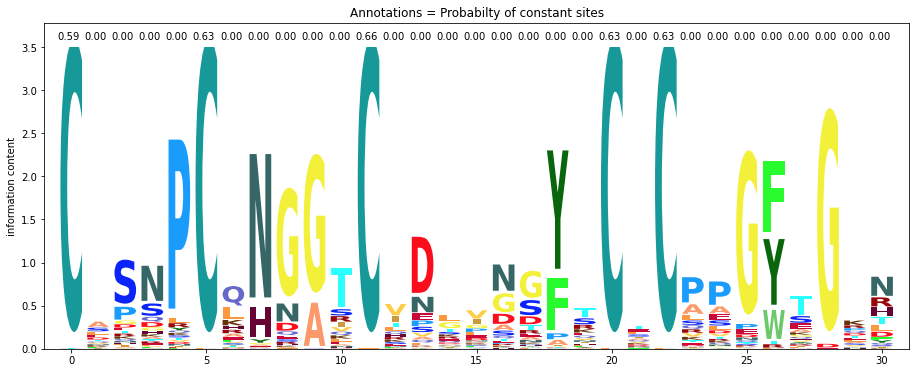

In [13]:
fig, ax = plt.subplots()
i = best_alignment.best_model
msa_hmm.vis.plot_logo(best_alignment, i, ax)
B = best_alignment.msa_hmm_layer.cell.emitter[0].make_B()[i]
model_len = best_alignment.msa_hmm_layer.cell.length[i]
for i,p in enumerate(B[1:1+model_len,1]):
    plt.annotate("%.2f" % p, (i-0.5, plt.ylim()[1]-0.2), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

In [ ]:
run_tests(constant_sites_runner, "constant_sites", datasets = ["homfam", "balifam10000"])

In [7]:
get_score("constant_sites", "homfam")

0.7946939970747141

In [10]:
get_score("constant_sites", "balifam10000")

0.7618033544375629

In [9]:
get_score("constant_sites_equilibirum_sampling", "homfam")

0.7928932067987374

In [11]:
get_score("constant_sites_equilibirum_sampling", "balifam10000")

0.7607131900530041

Constant sites have a positive effect of about 1% point on balifam10000.

### Experiment 2: Learn a family specific rate matrix.

Like the baseline but with a trainable rate matrix $Q$. Both the symmetric exchangeabilty matrix and the stationary distribution $\pi$ are trainable. We want to prevent a cheating model that maximizes likelihood by mutating all amino acids to a single one.

Reverse time sequence to consensus does not work in this case. $\mathcal{P}$ has only a horizontal constraint (sum to one) but not vertically. Because of this constraint, if $\mathcal{P}$ and $P(*\mid M)$ are freely trainable, both can converge to a solution with high "fake" likelihood that favours a single amino acid. In this case each row of $\mathcal{P}$ has a probability of almost 1 at one position and this position is the same for all rows. Consensus to sequence (which is essentially transposing $\mathcal{P}$) prevents this. Now $\mathcal{P}$ sums to one vertically instead of horizontally. This prevents the mapping of all amino acids to a single one, as columns consisting of large probabilities only can not exist anymore. 

In [5]:
def family_rate_runner(train_file, ref_file, out_file, config):
    config["trainable_rate_matrices"] = True 
    config["transposed"] = True 
    config["equilibrium_sample"] = True 
    config["matrix_rate_l2"] = 0.
    config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False, tau_init=-3)
    return msa_hmm.align.run_learnMSA(train_file,
                                      out_file,
                                      config, 
                                      ref_filename=ref_file, 
                                      verbose=True)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

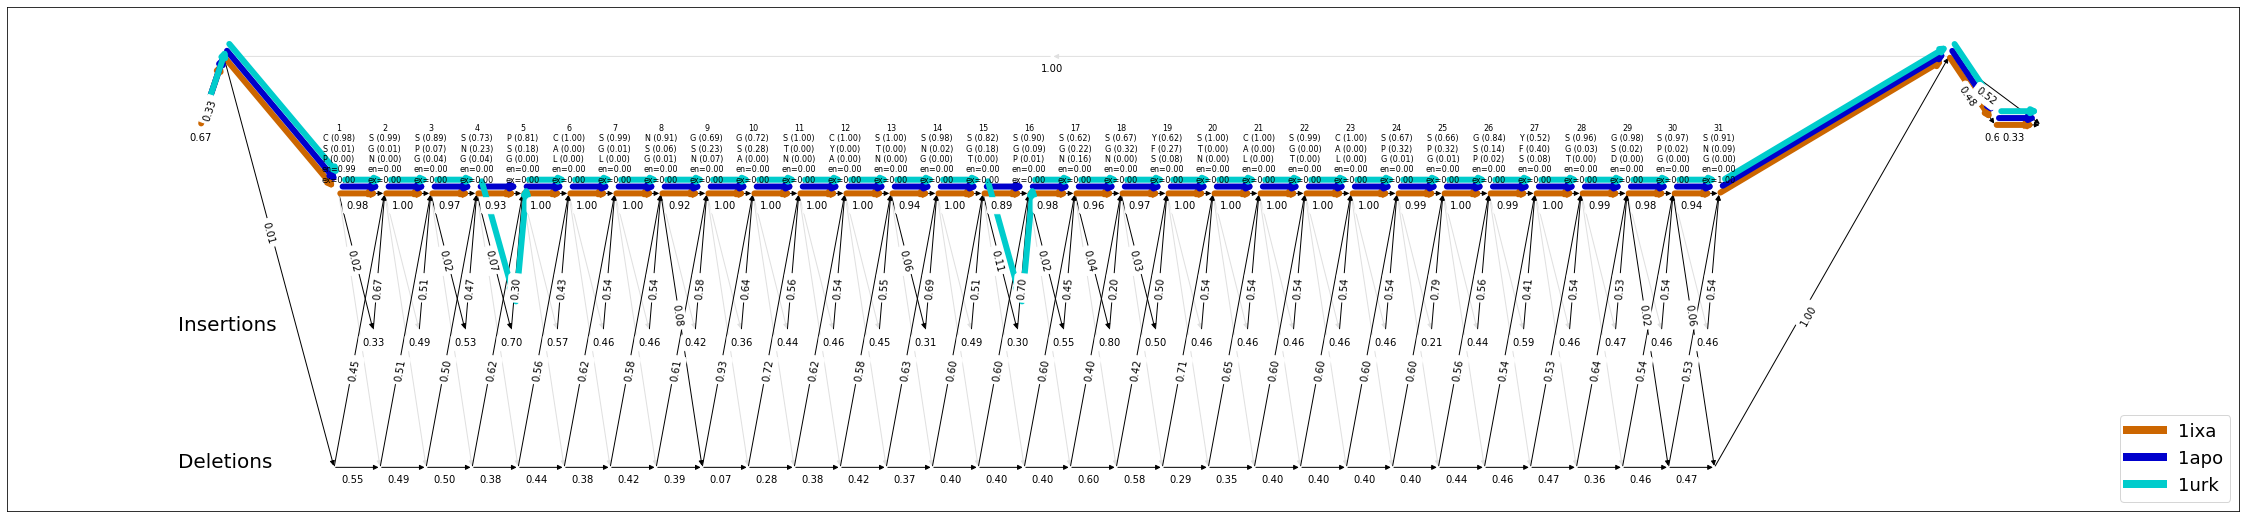

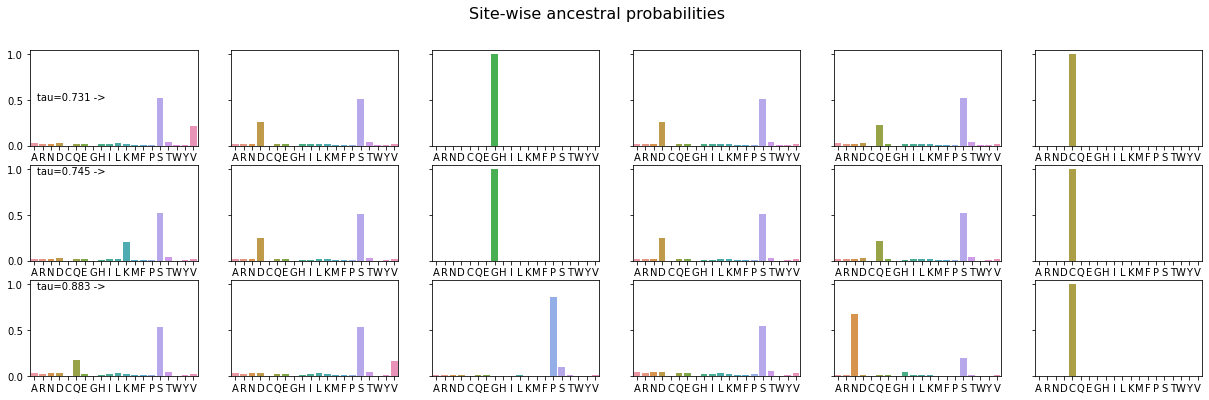

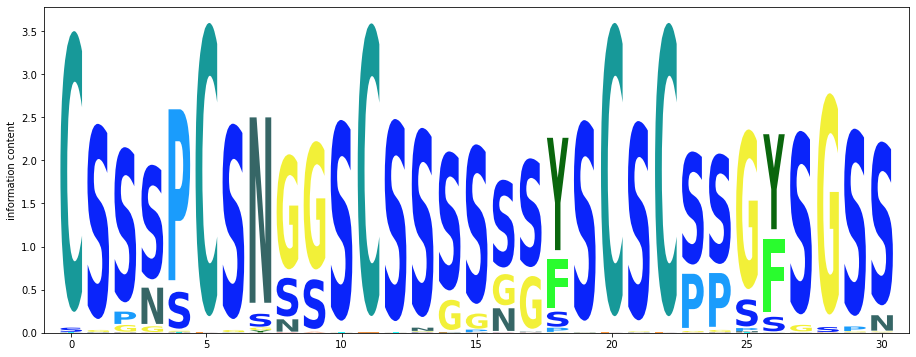

In [6]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
out_filename = "test.fasta"
config = msa_hmm.config.make_default(10)
best_alignment, r = family_rate_runner(train_filename, ref_filename, out_filename, config)
msa_hmm.vis.print_and_plot(best_alignment) 

In [ ]:
run_tests(family_rate_runner, "family_rate_equilibrium_sampling", datasets = ["homfam", "balifam10000"])

In [8]:
get_score("family_rate", "homfam")

0.7918325521970423

In [9]:
get_score("family_rate_equilibrium_sampling", "homfam")

0.4478308195927417

In [10]:
get_score("family_rate", "balifam10000")

0.7227655084155672

In [11]:
get_score("family_rate_equilibrium_sampling", "balifam10000")

0.38681611042900993

### Experiment 3: Train two rate matrices

In [6]:
def get_adaptive_batch_size(model_lengths, max_seq_len):
    model_length = max(model_lengths)
    if max_seq_len < 200 and model_length < 200:
        return 256
    elif max_seq_len < 520 and model_length < 290:
        return 128
    elif max_seq_len < 800 and model_length < 500:
        return 64
    else:
        return 32

def double_matrix_runner(train_file, ref_file, out_file, config):
    m = 2
    config["trainable_rate_matrices"] = True 
    config["transposed"] = True 
    config["matrix_rate_l2"] = 0.
    config["num_rate_matrices"] = m
    config["equilibrium_sample"] = False
    config["batch_size"] = get_adaptive_batch_size
    config["emitter"] = ReduceMultinomialEmitter(config["num_models"], num_rate_matrices = m, alpha = np.array([[180.0, 0.]]))
    R1 = msa_hmm.initializers.exchangeability_init
    R2 = msa_hmm.anc_probs.inverse_softplus(np.zeros_like(R1) + 1e-32)
    exchangeability_init = np.stack([R1, R2], axis=0)
    exchangeability_init = np.stack([exchangeability_init]*config["num_models"], axis=0)  
    equilibrium_init = np.stack([np.log(msa_hmm.initializers.p)]*m, axis=0)
    equilibrium_init = np.stack([equilibrium_init]*config["num_models"], axis=0)
    config["encoder_initializer"] = [msa_hmm.initializers.ConstantInitializer(-3), 
                                     msa_hmm.initializers.ConstantInitializer(exchangeability_init), 
                                     msa_hmm.initializers.ConstantInitializer(equilibrium_init)]
    config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False, tau_init=-3)
    return msa_hmm.align.run_learnMSA(train_file,
                                      out_file,
                                      config, 
                                      ref_filename=ref_file, 
                                      verbose=True)

In [ ]:
run_tests(double_matrix_runner, "double_matrix", datasets = ["homfam", "balifam10000"])

In [9]:
get_score("double_matrix", "homfam")

0.7927334548043745

In [10]:
get_score("double_matrix", "balifam10000")

0.7246677665001909

### Experiment 4: Train a local mutation rate per match state

$P(S \mid M_i) = Anc(S, \tau_{i} Q ) \cdot P_{M_i}$

with (as before)

$Anc(S, Q) = S^T \cdot expm(\tau_S Q)$

This could be a more flexible solution than Experiment 1 since any type of fast- or slowly-evolving position can be modeled under a shared substitution matrix.

**The direct approach with m * l different rate matricies (each product of sequence- and match-state-rate yields a unique matrix) is computationally intensive.** An indirect approach is more efficient and has probably the same effect:

Set a number of rate classes $c<l$ and soft-select from the $c$ rate matrices with a learned multinomial distribution per match. 

Also train an insertion specific rate or keep it constant?

### Experiment 5: Use a (fixed) mixture of rate matricies and learn the mixture coefficients

Pretrained mixture models already exist and should be solid (same authors as LG matrix that learnMSA uses). For instance, there is a secondary structure based mixture that was learned with class supervision (extended/helix/other). It would be interesting whether learnMSA can learn mixture coefficients per match state that reflect the real biologic background of this position.



In [16]:
def get_rate_and_equi():
    R_kernel_init, p_kernel_init = [],[]
    # parse LG4X rate matrix mixture
    for i in range(len(msa_hmm.anc_probs.LG4X_paml)):
        R_i, p_i = msa_hmm.anc_probs.parse_paml(msa_hmm.anc_probs.LG4X_paml[i], msa_hmm.fasta.alphabet[:-1])
        R_kernel_init.append(msa_hmm.anc_probs.inverse_softplus(R_i + 1e-32))
        p_kernel_init.append(np.log(p_i))
    # add a zero matrix to account for constant sites
    R_kernel_init.append(msa_hmm.anc_probs.inverse_softplus(np.zeros_like(R_kernel_init[-1]) + 1e-32))
    p_kernel_init.append(p_kernel_init[-1])
    return R_kernel_init, p_kernel_init
    

def LG4X_runner(train_file, ref_file, out_file, config):
    R_kernel_init, p_kernel_init = get_rate_and_equi()
    m = len(R_kernel_init)
    config["num_rate_matrices"] = m
    config["equilibrium_sample"] = False
    config["batch_size"] = get_adaptive_batch_size
    config["emitter"] = ReduceMultinomialEmitter(config["num_models"], num_rate_matrices = m, alpha = np.array([[70., 70., 70., 70., 0.]]))
    exchangeability_init = np.stack(R_kernel_init, axis=0)
    exchangeability_init = np.stack([exchangeability_init]*config["num_models"], axis=0)  
    equilibrium_init = np.stack(p_kernel_init, axis=0)
    equilibrium_init = np.stack([equilibrium_init]*config["num_models"], axis=0)
    config["encoder_initializer"] = [msa_hmm.initializers.ConstantInitializer(-3), 
                                     msa_hmm.initializers.ConstantInitializer(exchangeability_init), 
                                     msa_hmm.initializers.ConstantInitializer(equilibrium_init)]
    config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False, tau_init=-3)
    return msa_hmm.align.run_learnMSA(train_file,
                                      out_file,
                                      config, 
                                      ref_filename=ref_file, 
                                      verbose=True)

In [ ]:
f = "ghf13"
d = "homfam"
train_filename = "data/"+d+"/train/"+f+".fasta"
ref_filename = "data/"+d+"/refs/"+f+".ref"
out_filename = "test.fasta"
config = msa_hmm.config.make_default(10)
best_alignment, r = LG4X_runner(train_filename, ref_filename, out_filename, config)

In [ ]:
fig, ax = plt.subplots()
i = best_alignment.best_model
msa_hmm.vis.plot_logo(best_alignment, i, ax)
B = best_alignment.msa_hmm_layer.cell.emitter[0].make_B()[i]
model_len = best_alignment.msa_hmm_layer.cell.length[i]
for i,p in enumerate(B[1:1+model_len,4]):
    plt.annotate("%.2f" % p, (i-0.5, plt.ylim()[1]-0.2), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

In [ ]:
run_tests(constant_sites_runner, "LG4X", datasets = ["homfam", "balifam10000"])

In [24]:
get_score("LG4X", "homfam")

0.7942321482517627

In [25]:
get_score("LG4X_equilibrium_sampling", "homfam")

0.7951315688766402

In [26]:
get_score("LG4X", "balifam10000")

0.7681322510119968

^ LG4X improves balifam10000 prediction 

In [28]:
get_score("LG4X_equilibrium_sampling", "balifam10000")

0.7607072662392034

### Experiment 7: Can we incorporate ClaMSA? Train $Q_1, .. , Q_M$?

### Experiment 8: Use a fixed symmetric part $R$ but replace the generic $\pi$ with the distribution from the match state